# NaiveSAM

## Toolkits

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # ex: width:1200px

In [2]:
%load_ext autoreload
%autoreload 2

# load the naivesam tools
from naivesam import (nas_show_points, 
                      nas_show_mask, 
                      nas_draw_masklets_cv2,
                      nas_draw_and_save_masklets_cv2,
                      nas_masklets_to_yolo_seg_txt,
                      nas_group_images_labels_to_yolo_data_dir,
                      nas_create_yoylo_seg_dataset,
                      NaiveSamTool)

In [3]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import cv2
import glob
import torch
import shutil
import pickle

import numpy as np
import ipywidgets as ipyw
import matplotlib.pyplot as plt


from PIL import Image
from tqdm import tqdm
from ipywidgets import widgets, GridspecLayout
from sam2.build_sam import build_sam2_video_predictor
from sklearn.model_selection import train_test_split


In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


# 1. Extracting frames from video

#### set video dir with your own path

In [5]:
# videos
videos_list = [
"20250602-2_720x480.mp4",
"20250602-2_720x480_end.mp4"]


# root folder
folder_path = "./robot_example/videos/"

# labeled frame out folder
out_mask_path = "./robot_example/out_mask/"

# labeled video out folder
out_vid_path = "./robot_example/out_vid/"

# output YOLO dataset
yolo_data = "./robot_example/yolo_data/"




video_name = videos_list[1]
print('video_name=', video_name)

# 結合資料夾路徑和影片名稱
video_path = os.path.join(folder_path, video_name)
print('video_path=', video_path)

# 移除副檔名
video_dir, ext = os.path.splitext(video_path)
print('video_dir=', video_dir)


framerate = 5 #10
print('framerate=', framerate)

video_name= 20250602-2_720x480_end.mp4
video_path= ./robot_example/videos/20250602-2_720x480_end.mp4
video_dir= ./robot_example/videos/20250602-2_720x480_end
framerate= 5


#### convert video to frames

In [6]:
# mkdir video name dir 
!rm -rf {video_dir}

!mkdir {video_dir}

!ffmpeg -i {video_path} -q:v 2 -r {framerate} -start_number 0 {video_dir}/%05d.jpg -loglevel quiet -stats

frame=  270 fps=144 q=2.0 Lsize=N/A time=00:00:54.00 bitrate=N/A dup=0 drop=1340 speed=28.7x    


In [7]:
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]

frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))  # NMH

frame_count = len(frame_names)

print("frame_count         ", frame_count)
print("check names", video_name)
print("check names", frame_names[:3])


# check image size
temp_frame_0 = Image.open(os.path.join(video_dir, frame_names[0]))

W = temp_frame_0.size[0]
H = temp_frame_0.size[1]

print(type(temp_frame_0))
print('(w, h) :', temp_frame_0.size)
print('W:', temp_frame_0.size[0])
print('H:', temp_frame_0.size[1])

frame_count          270
check names 20250602-2_720x480_end.mp4
check names ['00000.jpg', '00001.jpg', '00002.jpg']
<class 'PIL.JpegImagePlugin.JpegImageFile'>
(w, h) : (720, 480)
W: 720
H: 480


# 2. NaiveSAM

set SAM and predictor

In [8]:
# local path for model checkpoint and configuration.
sam2_checkpoint = "../sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

# load frames to predictor
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 270/270 [00:06<00:00, 44.71it/s]


Labeling 


In [9]:
# --- ipywidgets --- #

# hold all the clicks pts when add
prompts = {}
# hold temp pts per frame
obj_pts_list = []
# default frame start from 0
out_frame_idx = 0

# Labels: [UR10] (**Please change it to the category you need**)
class_list = widgets.RadioButtons(
    options=["0 robot", "1 clamp", "2 camera", "3 scanner", "4 control_panel", "5 ROS_panel", "6 object"],
    description='Labels:',
    layout=ipyw.Layout(height='auto', width='auto'),
    disabled=False
)

# Label is 1 or 0 (positive or negative, default 1)
ng = widgets.Checkbox(
    value=True,
    description='positive point',
    disabled=False,
    button_style='',
    tooltips=['Negative points are used to exclude background', 'Positive points represent target objects'],
)

int_range = ipyw.IntSlider(max=frame_count-1, description='Frame:', layout=ipyw.Layout(width='400px'))
int_range.style.handle_color = 'lightblue'
frame_count_output = ipyw.Output()

pts_save_button = ipyw.Button(description=" Save pts by frame", button_style='primary', icon='floppy-o',
                             layout={'border': '2px solid gray', 'width': 'auto'})
pts_save_button_output = ipyw.Output()

pts_clear_button = ipyw.Button(description=" Clear pts", button_style='warning', icon='eraser',
                               layout={'border': '2px solid gray', 'width': '60%'})
pts_clear_button_output = ipyw.Output()

pts_list_out = ipyw.Output(layout={'border': '2px solid gray', 'width': '50%'})

<IPython.core.display.Javascript object>


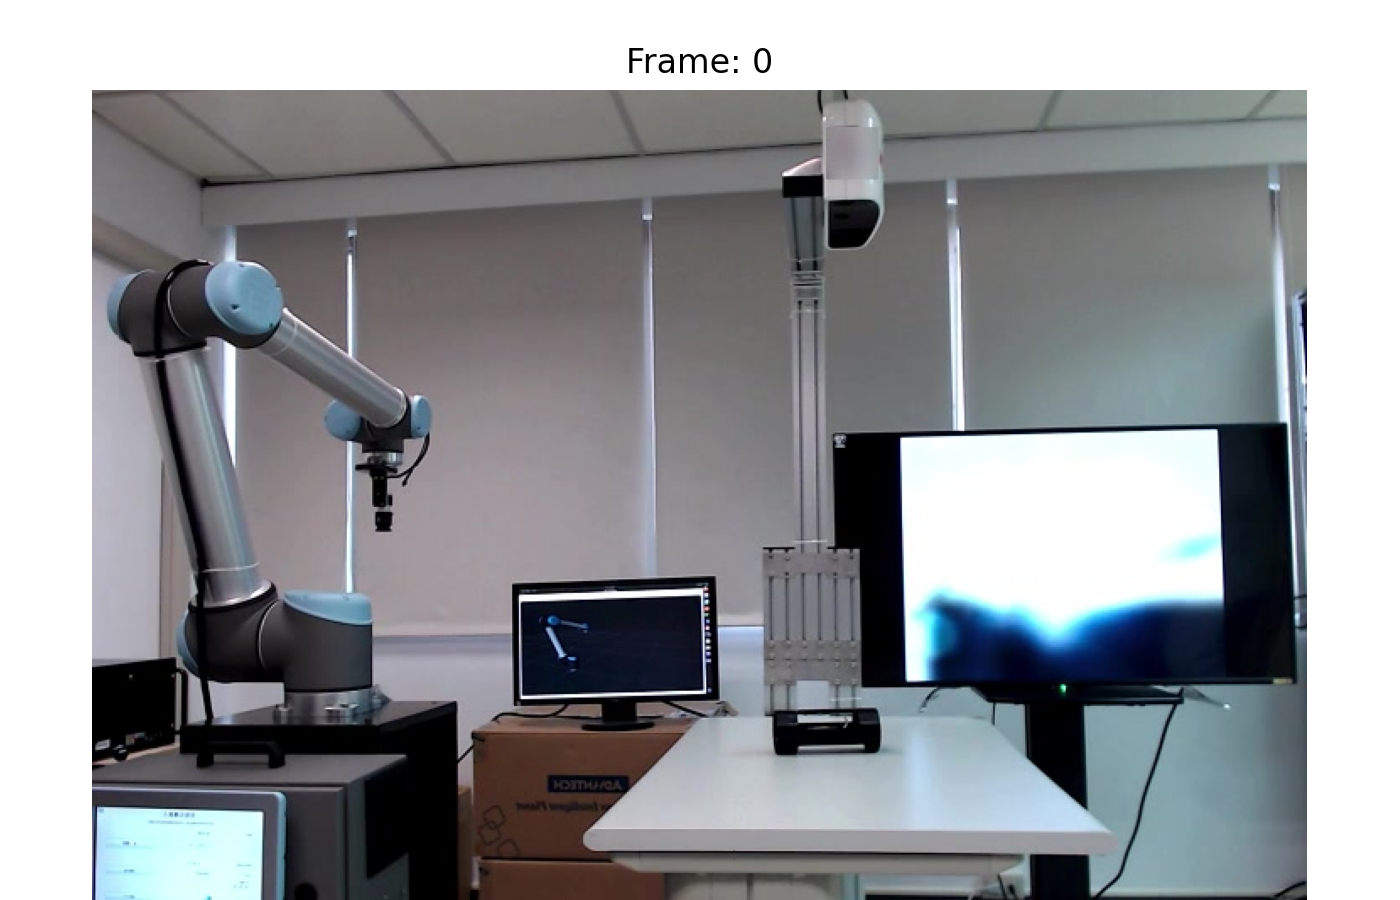

GridspecLayout(children=(IntSlider(value=0, description='Frame:', layout=Layout(grid_area='widget001', width='…

In [10]:
# # Please enable interactive charts in the notebook. (If you don't add a notebook, it will interact with the native OS and you will not be able to control the interface.)
%matplotlib notebook

# Matplotlib figure and axes
fig, ax = plt.subplots(num="NaiveSAM @Jupyter Widgets", figsize=(7.,4.5))

# --- NaiveSAM --- #
nas = NaiveSamTool(
    predictor_instance=predictor, 
    inference_state_instance=inference_state, 
    show_points_func=nas_show_points, 
    show_mask_func=nas_show_mask, 
    frame_count=frame_count,
    video_dir=video_dir,
    frame_names=frame_names,
    folder_path=folder_path, 
    video_name_for_pts=video_name, 

    # Passing instances of all ipywidgets and Matplotlib objects
    class_list_widget=class_list,
    ng_widget=ng,
    int_range_widget=int_range,
    frame_count_output_widget=frame_count_output,
    pts_list_out_widget=pts_list_out,
    pts_save_button_widget=pts_save_button,
    pts_save_button_output_widget=pts_save_button_output,
    pts_clear_button_widget=pts_clear_button,
    pts_clear_button_output_widget=pts_clear_button_output,
    figure_instance=fig,
    axes_instance=ax
)

# --- Display application UI ---
nas.display_app()

#### predictor : Propagate the prompts (the pts you labeled).

In [11]:
# merge all vids_frame#.pts to video_name.pts
nas.merge_pts()

# add pts: Add new points by "obj_pts_list"
nas.add_new_pts_to_predictor()

# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }


Add pts to predictor:
	[0, 0, 1, 89, 328]
	[0, 1, 1, 169, 205]
	[0, 2, 1, 175, 258]
	[0, 3, 1, 454, 62]
	[0, 4, 1, 103, 424]
	[0, 5, 1, 313, 370]
	[0, 6, 1, 455, 384]


propagate in video: 100%|██████████| 270/270 [03:34<00:00,  1.26it/s]


# 3. Display mask result

### Draw the "propagation" result or save it as a video

#### Please check whether the automatic segmentation result in the video is correct before performing the final mask-to-YOLO conversion process.

In [12]:
# Delete temp out put masklets images
!rm -rf {out_mask_path}/*.*g

# render the segmentation results every few frames for save time and space
vis_frame_stride = 5 #1 #10

# draw/save masklets to jpg
nas_draw_and_save_masklets_cv2(video_dir, frame_names, vis_frame_stride, out_mask_path, video_segments)

100%|██████████| 54/54 [00:02<00:00, 21.26it/s]


In [13]:
mp4name = f"vid_{video_name}_s{vis_frame_stride}_r{framerate}_cv2.mp4"
!ffmpeg -y -framerate {framerate} -i '{out_mask_path}/%05d.jpg' -r {framerate} {out_vid_path}{mp4name} -loglevel quiet -stats #-hide_banner

frame=   54 fps=0.0 q=-1.0 Lsize=     697kB time=00:00:10.20 bitrate= 560.1kbits/s speed=17.1x    


In [14]:
from IPython.display import Video
Video(f'{out_vid_path}{mp4name}', embed=False, width=600, height=500)#, html_attributes="loop autoplay")

## 4. Convert SAM masklets to YOLO formate
`Note: If you have multiple videos, please repeat the tagging process for all videos before compiling the complete dataset.`

In [15]:
vis_frame_stride = 1

for out_frame_idx in tqdm(range(0, len(frame_names), vis_frame_stride)):
    nas_masklets_to_yolo_seg_txt(out_frame_idx, video_dir, frame_names, vis_frame_stride, video_segments)
    

100%|██████████| 270/270 [00:03<00:00, 72.36it/s]


In [16]:
!ls {video_dir}

00000.jpg  00039.jpg  00078.jpg  00117.jpg  00156.jpg  00195.jpg  00234.jpg
00000.txt  00039.txt  00078.txt  00117.txt  00156.txt  00195.txt  00234.txt
00001.jpg  00040.jpg  00079.jpg  00118.jpg  00157.jpg  00196.jpg  00235.jpg
00001.txt  00040.txt  00079.txt  00118.txt  00157.txt  00196.txt  00235.txt
00002.jpg  00041.jpg  00080.jpg  00119.jpg  00158.jpg  00197.jpg  00236.jpg
00002.txt  00041.txt  00080.txt  00119.txt  00158.txt  00197.txt  00236.txt
00003.jpg  00042.jpg  00081.jpg  00120.jpg  00159.jpg  00198.jpg  00237.jpg
00003.txt  00042.txt  00081.txt  00120.txt  00159.txt  00198.txt  00237.txt
00004.jpg  00043.jpg  00082.jpg  00121.jpg  00160.jpg  00199.jpg  00238.jpg
00004.txt  00043.txt  00082.txt  00121.txt  00160.txt  00199.txt  00238.txt
00005.jpg  00044.jpg  00083.jpg  00122.jpg  00161.jpg  00200.jpg  00239.jpg
00005.txt  00044.txt  00083.txt  00122.txt  00161.txt  00200.txt  00239.txt
00006.jpg  00045.jpg  00084.jpg  00123.jpg  00162.jpg  00201.jpg  00240.jpg
00006.txt  0

## 5. Sort out and pack to YOLO-seg dataset

### CP and Rename the jpg/txt

In [17]:
# Clear previous dataset
!rm -rf {yolo_data}/*.txt
!rm -rf {yolo_data}/*.jpg

In [18]:
nas_group_images_labels_to_yolo_data_dir(videos_list, folder_path, yolo_data)

videos_list: ['20250602-2_720x480.mp4', '20250602-2_720x480_end.mp4']


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

* Total count: 270


In [19]:
# Check number of pair
!ls -l {yolo_data}/*.txt | wc -l
!ls -l {yolo_data}/*.jpg | wc -l

270
270


### Move jpg/txt and create Train/Val split

In [20]:
# Clear previous dataset
!rm -rf {yolo_data}/images/
!rm -rf {yolo_data}/labels/

In [21]:
os.makedirs(f"{yolo_data}/images/train")
os.makedirs(f"{yolo_data}/images/val")
os.makedirs(f"{yolo_data}/labels/train")
os.makedirs(f"{yolo_data}/labels/val")

In [22]:
!tree -d {yolo_data}

./robot_example/yolo_data/
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories


In [23]:
nas_create_yoylo_seg_dataset(yolo_data)

* txt_path_ls len: 270
* train: 216, val: 54
* s_train[:3]:['./robot_example/yolo_data//20250602-2_720x480_end.mp4_00115.txt', './robot_example/yolo_data//20250602-2_720x480_end.mp4_00033.txt', './robot_example/yolo_data//20250602-2_720x480_end.mp4_00184.txt'] 
* s_val[:3]:  ['./robot_example/yolo_data//20250602-2_720x480_end.mp4_00030.txt', './robot_example/yolo_data//20250602-2_720x480_end.mp4_00116.txt', './robot_example/yolo_data//20250602-2_720x480_end.mp4_00079.txt']
* jpg_train: 216, val: 54
* jpg_train[:3]:['./robot_example/yolo_data//20250602-2_720x480_end.mp4_00115.jpg', './robot_example/yolo_data//20250602-2_720x480_end.mp4_00033.jpg', './robot_example/yolo_data//20250602-2_720x480_end.mp4_00184.jpg'] 
* s_val[:3]:  ['./robot_example/yolo_data//20250602-2_720x480_end.mp4_00030.jpg', './robot_example/yolo_data//20250602-2_720x480_end.mp4_00116.jpg', './robot_example/yolo_data//20250602-2_720x480_end.mp4_00079.jpg']


In [24]:
!tree -L 3 {yolo_data}

./robot_example/yolo_data/
├── images
│   ├── train
│   │   ├── 20250602-2_720x480_end.mp4_00000.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00001.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00002.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00003.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00004.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00005.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00007.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00008.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00010.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00011.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00012.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00013.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00014.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00016.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00017.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00018.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00020.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00021.jpg
│   │   ├── 20250602-2_720x480_end.mp4_00023.jpg
│   │   ├── 20250

Now you can train YOYLO-seg with custom dataset.

## End of NaiveSAM